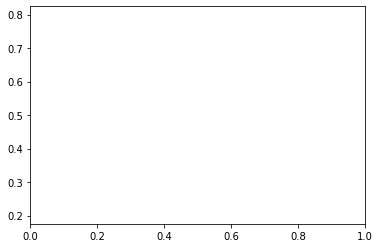

In [1]:
# Setup and import
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from math import *

plt.axes().set_aspect('equal', 'datalim')
plt.rcParams['figure.figsize'] = [15, 15]

AbaqusINP = 'Init_Rot'

In [2]:
# READ INITIAL INPUT FILE
# Function to extract nodal coordinates
def readINPUT(AbaqusINP):
    # Open file to read and write
    linesINP = open(AbaqusINP+".inp",'r')
    nodeInf = open(AbaqusINP+"NodeInf.txt",'w')
    
    # Read lines in initial input file and collect info
    for line in linesINP:
        if '*Node' in line:
            for line in linesINP:
                if '*Node' in line:
                    continue
                elif line.startswith('*Element, type=CPS4'): # It should be checked what types of element is used
                    linesINP.close()
                    nodeInf.close()
                    return

                nodeInf.write(line)

In [3]:
# Load Coordinates into NumPy Array
readINPUT(AbaqusINP)
coords = np.loadtxt(AbaqusINP+"NodeInf.txt", delimiter=',')

# Print to ensure the file was actually loaded
print(coords)

[[ 1.00000000e+00 -7.95546112e+01 -1.58904114e+02]
 [ 2.00000000e+00 -5.62500000e+01 -7.50000000e+01]
 [ 3.00000000e+00 -9.37500000e+01  7.02399979e+01]
 ...
 [ 1.25590000e+04  1.08287750e+02  1.33222456e+01]
 [ 1.25600000e+04  1.10872574e+02  1.47962103e+01]
 [ 1.25610000e+04  1.13470741e+02  1.62668934e+01]]


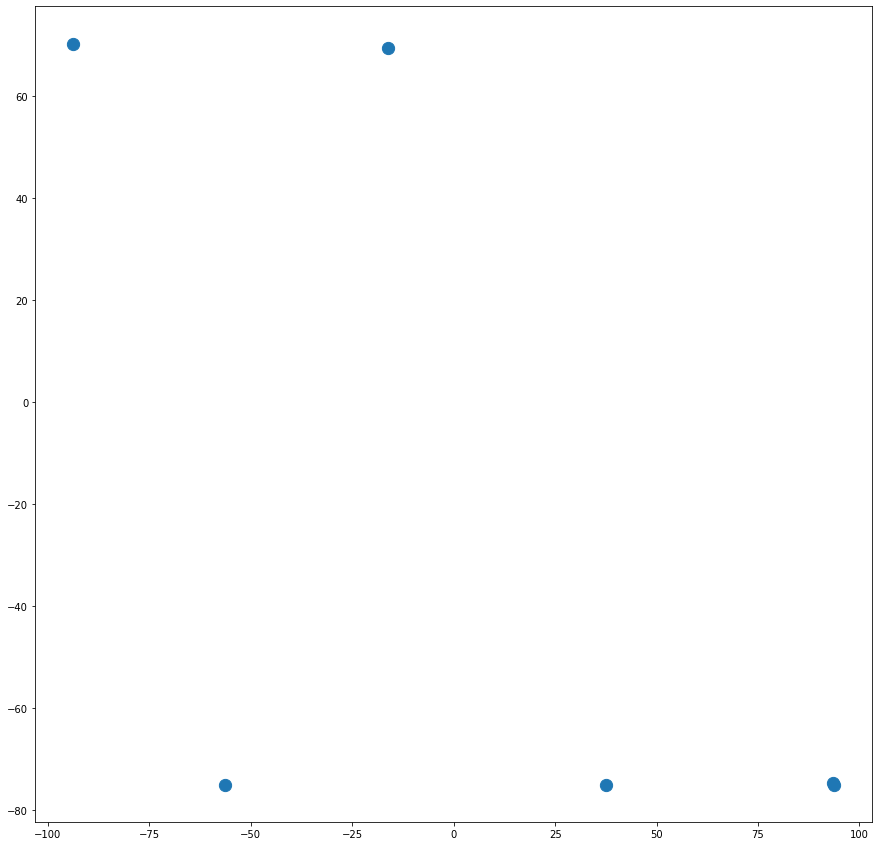

In [4]:
# Define Significant Points 
origin = np.array([0., 0.]) 
P1 = np.array([-56.25, -75.])
P2 = np.array([-93.75, 70.24])
P3 = np.array([93.75, -75.])
P4 = np.array([37.5, -75.])
P5 = np.array([93.5, -74.75])
P6 = np.array([-16.173612, 69.287935])

# Plot points to ensure accuracy
x1, y1 = np.array([P1, P2, P3, P4, P5, P6]).T
plt.scatter(x1, y1, s = 150)

In [5]:
# OBTAIN POINTS TO FIX THE EDGE OF THE FLAP
# Initialize lists
inside = [] #F or plotting
outside = [] # For plotting
fix = [] # For updating input file
free = [] # For obtaining output info

#Iterate through coordinates
for coord in coords:
    # Grab a coordinate
    xi, yi = float(coord[1]), float(coord[2])
    edge = np.linalg.norm(np.array([5., 0.])-np.array([xi, yi])) # Adjusted to 5, flap not centered at origin
    if abs(edge - 180.) >= 0.1: 
        inside.append([xi, yi])
        free.append(coord[0])
    else:
        outside.append([xi, yi])
        fix.append(coord[0])


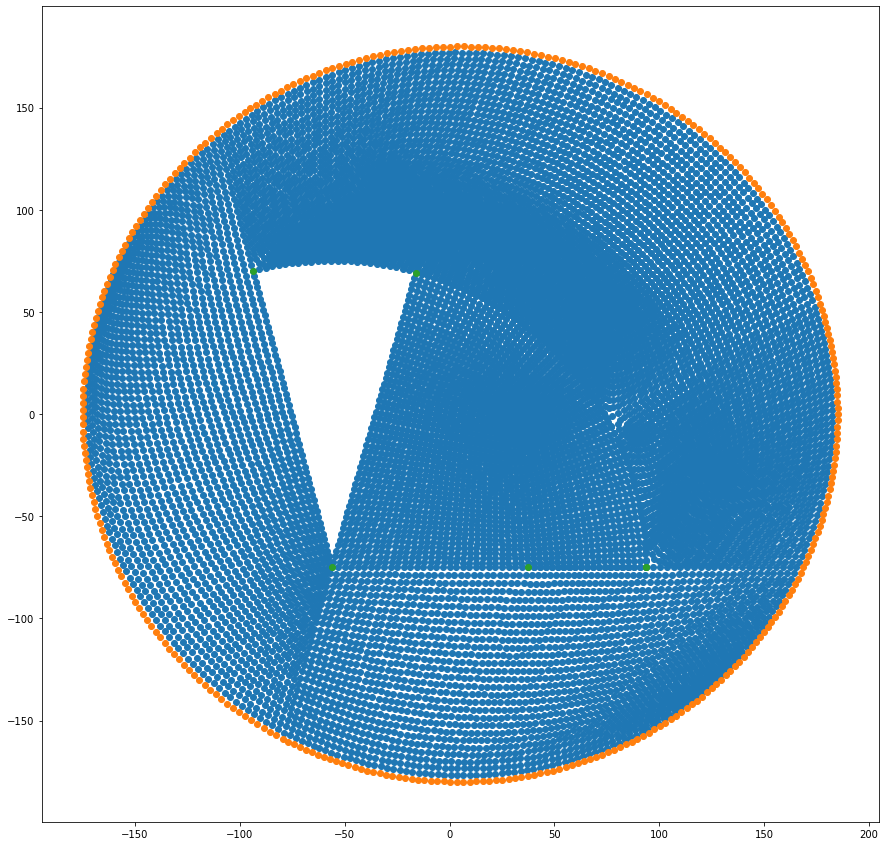

In [6]:
# Plot fixed points in orange and unfixed points in blue to confirm accuracy
# Also plot points of interest
x, y = np.array(inside).T
xout, yout =np.array(outside).T
plt.scatter(x, y)
plt.scatter(xout, yout)
plt.scatter(x1, y1)



In [7]:
# Output free nodes to a text file - used to collect info from abaqus outputs
with open('rot60_12500.txt', 'w') as f:
    for n in free:
        f.write("%d\n" % n)
        
# Also write all the nodes
with open('rot60_12500_all.txt', 'w') as f:
    for i in range(1, len(coords) + 1):
        f.write("%d\n" % i) 

In [8]:
# LOCATE THE EDGES OF THE FLAP GEOMETRY FOR STITCHING
# Define distances
r_large = 150.003025
r_small = 149.75
# Define lists to store coordinates and node numbers
leftLINE_x, leftLINE_y = [], []
rightLINE_x, rightLINE_y = [], []
leftLINE_node, rightLINE_node = [], []
largeCIRC_x, largeCIRC_y = [], []
smallCIRC_x, smallCIRC_y = [], []
largeCIRC_node, smallCIRC_node = [], []
upTRI_x, upTRI_y = [], []
lowTRI_x, lowTRI_y = [], []
upTRI_node, lowTRI_node = [], []

# Iterate through coordinates to find stitch points
for coord in coords:
    # Grab a coordinate
    nodei, xi, yi = float(coord[0]), float(coord[1]), float(coord[2])
    
    # Only check the coordinate if it's x value is between P1 and P6
    if xi >= P2[0] and xi <= P3[0]:
        
        # Define perimeter of the 2 circles
        circle1 = (xi-P1[0])**2. + (yi-P1[1])**2. - r_small**2.
        circle2 = (xi-P1[0])**2. + (yi-P1[1])**2. - r_large**2.
        
        # Define left triangle line
        points = [P1,P2]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line1 = m * xi + c
        
        # Define right triangle line
        points = [P1,P6]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line2 = m * xi + c
        
        # Define up triangle line
        points = [P5,P4]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line3 = m * xi + c
        
        # Define low triangle line
        points = [P3,P4]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line4 = m * xi + c
        a=0
        
        # Determine if point is on small circle perimeter
        if xi <= P5[0] and xi > P6[0] and circle1 <= 0.1 and circle1 >= -0.1:
            smallCIRC_x.append(xi)
            smallCIRC_y.append(yi)
            smallCIRC_node.append(nodei)
            
        # Determine if point is on large circle perimeter
        elif xi < P3[0] and xi > P2[0] and circle2 <= 0.4 and circle2 >= -0.40:
            largeCIRC_x.append(xi)
            largeCIRC_y.append(yi)
            largeCIRC_node.append(nodei)
            
        # Determine if point is on left line
        elif yi > P1[1] and yi <= P2[1] and abs(line1-yi) <= 4:
            leftLINE_x.append(xi)
            leftLINE_y.append(yi)
            leftLINE_node.append(nodei)
            
        # Determine if point is on right line
        elif yi > P1[1] and yi <= P6[1] and abs(line2-yi) <= 4: #FIXME
            rightLINE_x.append(xi)
            rightLINE_y.append(yi)
            rightLINE_node.append(nodei)
        
        # Determine if point is on lower line segment
        elif xi > P4[0] and xi < P3[0] and abs(P3[1]-yi) <= 0.000001:
            lowTRI_x.append(xi)
            lowTRI_y.append(yi)
            lowTRI_node.append(nodei)
                
        # Determine if point is on upper line segment
        elif xi > P4[0] and xi <= P5[0] and abs(line3 - yi) <= 0.001:
            upTRI_x.append(xi)
            upTRI_y.append(yi)
            upTRI_node.append(nodei)


C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`

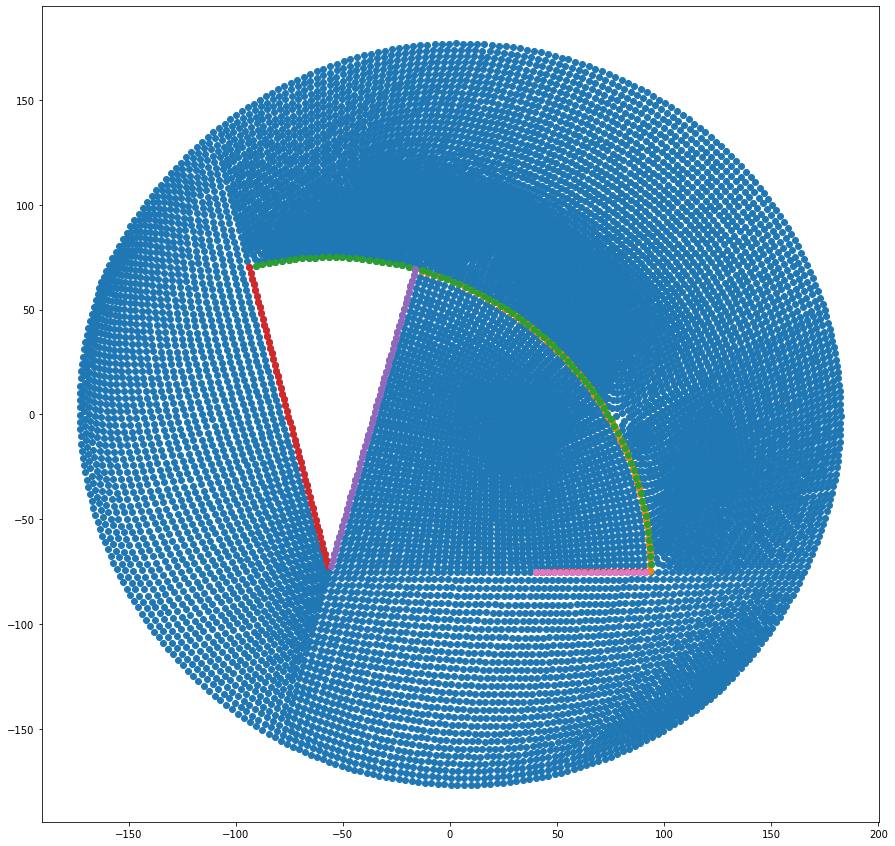

In [9]:
# Plot the results of the stitch points
# Each quarter circle, flat line, and triangle segment should be a different color
plt.scatter(x, y)
plt.scatter(smallCIRC_x, smallCIRC_y)
plt.scatter(largeCIRC_x, largeCIRC_y)
plt.scatter(leftLINE_x, leftLINE_y)
plt.scatter(rightLINE_x, rightLINE_y)
plt.scatter(upTRI_x, upTRI_y)
plt.scatter(lowTRI_x, lowTRI_y)

In [10]:
# Split the larger circle segment - part of it is used in the Y junction
# Determine how many nodes are needed
num_split = len(lowTRI_node)

# Order the large circle nodes and coordinates by increasing x values - you want the ones with the biggest x values
ordered_nodes_largeCIRC = [x for _,x in sorted(zip(largeCIRC_x,largeCIRC_node))]
ordered_y_largeCIRC = [x for _,x in sorted(zip(largeCIRC_x,largeCIRC_y))]
ordered_x_largeCIRC = sorted(largeCIRC_x)

# Grab the last ones - however many you calculate you need above
rightTRI_x = ordered_x_largeCIRC[-1*num_split:]
rightTRI_y = ordered_y_largeCIRC[-1*num_split:]
rightTRI_node = ordered_nodes_largeCIRC[-1*num_split:]

# Ensure these are also removed from the large circle
largeCIRC_x = ordered_x_largeCIRC[0:0-num_split]
largeCIRC_y = ordered_y_largeCIRC[0:0-num_split]
largeCIRC_node = ordered_nodes_largeCIRC[0:0-num_split]

(-194.53348186478541,
 204.54002786478537,
 -199.56744802147017,
 199.56834802147017)

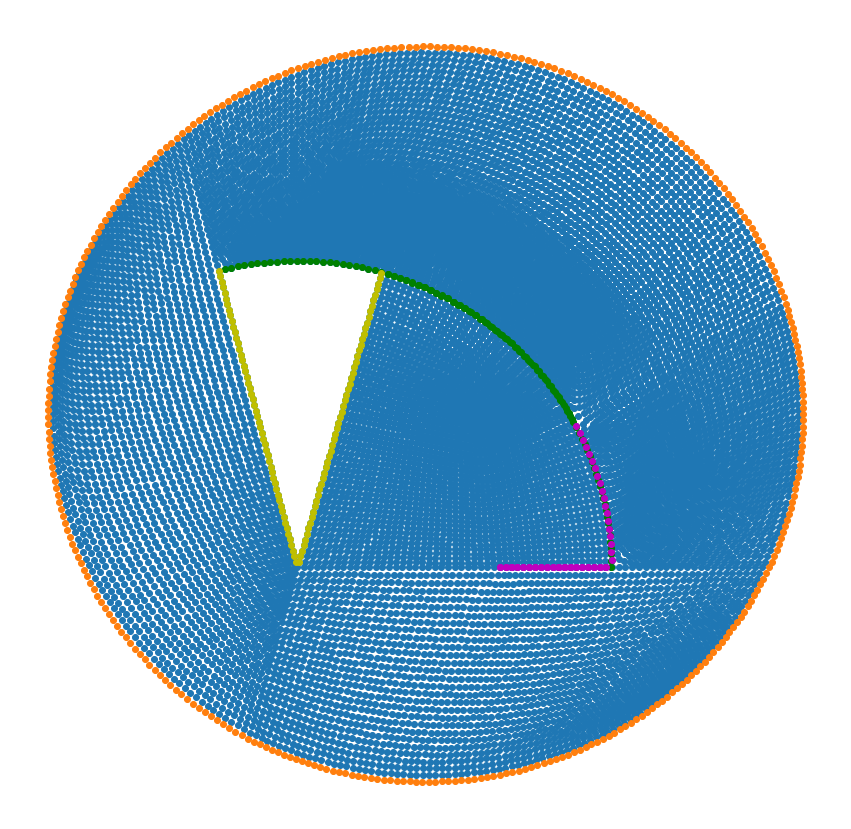

In [11]:
# Plot the results of the stitch points
# Each quarter circle, flat line, and triangle segment should be a different color
plt.scatter(x, y)
plt.scatter(xout, yout)
plt.scatter(smallCIRC_x, smallCIRC_y,c='g')
plt.scatter(largeCIRC_x, largeCIRC_y,  c='g')
plt.scatter(leftLINE_x, leftLINE_y, c='y')
plt.scatter(rightLINE_x, rightLINE_y, c='y')
plt.scatter(upTRI_x, upTRI_y, c='m')
plt.scatter(lowTRI_x, lowTRI_y, c='m')
plt.scatter(rightTRI_x, rightTRI_y, c='m')
plt.axis('off')



In [12]:
# Approximate lengths of the parts of the circle that match up
large_distance = 0
for i in range(0, len(largeCIRC_x)-1):
    large_distance += sqrt((largeCIRC_x[i] - largeCIRC_x[i+1])**2 + (largeCIRC_y[i] - largeCIRC_y[i+1])**2 )
    
small_distance = 0
ordered_y_smallCIRC = [x for _,x in sorted(zip(smallCIRC_x,smallCIRC_y))]
ordered_x_smallCIRC = sorted(smallCIRC_x)

for i in range(0, len(ordered_x_smallCIRC)-1):
    small_distance += sqrt((ordered_x_smallCIRC[i] - ordered_x_smallCIRC[i+1])**2 + (ordered_y_smallCIRC[i] - ordered_y_smallCIRC[i+1])**2 )

# You want to ensure that the large distance is bigger than the small distance, otherwise you're trying to compress the smaller circle into the larger circle
print(large_distance)
print(small_distance)

194.5214740389895
191.3169966371973


In [13]:
# PAIR NODES FOR STITCHING
# **NOTE**: The segements need to have equal numbers of nodes
# Function to do this for line and circle segments
def pairStitches(iNode, oNode, innerx, innery, outerx, outery, segment):
    distances = []
    stitchO = []
    stitchI = []
    
    # Circle segment
    if (segment == 'circ'):
        # Sort by increasing x value
        oNode = [x for _,x in sorted(zip(outerx,oNode))]
        outery = [x for _,x in sorted(zip(outerx,outery))]
        outerx = sorted(outerx) 
        
        # Pair to the closest node
        for i in range(0, len(outerx)):
            xouter, youter = outerx[i], outery[i]
            node = oNode[i]
            nodeStitch = 0;
            distanceBest = 10**10.
            for j in range(0, len(innerx)):
                xinner, yinner = innerx[j], innery[j]
                distance = sqrt((xouter - xinner)**2. + (youter - yinner)**2.)
                if distance < distanceBest:
                    distanceBest = distance
                    nodeStitch = iNode[j]
                    index = j
            innerx.pop(index)
            innery.pop(index)
            iNode.pop(index)

            stitchO.append(node)
            stitchI.append(nodeStitch)
            distances.append(distanceBest)
           
    # Line segment
    elif (segment=='line'):
        # Sort by increasingx value
        iNode = [x for _,x in sorted(zip(innerx,iNode))]
        innery = [x for _,x in sorted(zip(innerx,innery))]
        innerx = sorted(innerx)
        
        # Pair to the closest node
        for i in range(0, len(innerx)):
            xinner, yinner = innerx[i], innery[i]
            node = iNode[i]
            nodeStitch = 0;
            distanceBest = 10.**10.
            for j in range(0, len(outerx)):
                xouter, youter = outerx[j], outery[j]
                distance = sqrt((xouter - xinner)**2. + (youter - yinner)**2.)
                if distance < distanceBest:
                    distanceBest = distance
                    nodeStitch = oNode[j]
                    index = j
            outerx.pop(index)
            outery.pop(index)
            oNode.pop(index)
            
            stitchI.append(node)
            stitchO.append(nodeStitch)
            distances.append(distanceBest)
            
    # Make sure you didn't spell anything wrong
    else:
        print('That segment doesnt exist')
        
    return [stitchO, stitchI, distances]

# Create the Y junction
def pairStitches_triangle(upTRI_node, lowTRI_node, rightTRI_node, upTRI_x, upTRI_y, lowTRI_x, lowTRI_y, rightTRI_x, rightTRI_y):
    num_nodes = len(upTRI_node)
    distances = []
    stitchO = []
    stitchI = []
    
    #Sort all nodes by increasing x coordinate value
    upTRI_node_sorted = [x for _,x in sorted(zip(upTRI_x,upTRI_node))]
    upTRI_y_sorted = [x for _,x in sorted(zip(upTRI_x,upTRI_y))]
    upTRI_x_sorted = outerx = sorted(upTRI_x)
    
    lowTRI_node_sorted = [x for _,x in sorted(zip(lowTRI_x,lowTRI_node))]
    lowTRI_y_sorted = [x for _,x in sorted(zip(lowTRI_x,lowTRI_y))]
    lowTRI_x_sorted = outerx = sorted(lowTRI_x)
        
    rightTRI_node_sorted = [x for _,x in sorted(zip(rightTRI_y,rightTRI_node))]
    rightTRI_x_sorted = [x for _,x in sorted(zip(rightTRI_y,rightTRI_x))]
    rightTRI_y_sorted = outerx = sorted(rightTRI_y)
    
    # Pair segment 1
    for i in range(0, floor(num_nodes/2)):
        stitchO.append(lowTRI_node_sorted[i])
        stitchI.append(upTRI_node_sorted[i])
        distances.append(sqrt((lowTRI_x_sorted[i] - upTRI_x_sorted[i])**2. + (lowTRI_y_sorted[i] - upTRI_y_sorted[i])**2.))
    
    # Pair segment 2
    for i in range(ceil(num_nodes/2), num_nodes):
        stitchO.append(rightTRI_node_sorted[i])
        stitchI.append(upTRI_node_sorted[i])
        distances.append(sqrt((rightTRI_x_sorted[i] - upTRI_x_sorted[i])**2. + (rightTRI_y_sorted[i] - upTRI_y_sorted[i])**2.))
    
    # Pair segment 3
    j = num_nodes - 1
    for i in range(0, floor(num_nodes/2)):
        stitchO.append(rightTRI_node_sorted[i])
        stitchI.append(lowTRI_node_sorted[j])
        distances.append(sqrt((rightTRI_x_sorted[i] - lowTRI_x_sorted[j])**2. + (rightTRI_y_sorted[i] - lowTRI_y_sorted[j])**2.))
        j-=1
        
        
    # 3 way stitch
    index = floor(num_nodes/2)
    stitchO.append(lowTRI_node_sorted[index])
    stitchI.append(upTRI_node_sorted[index])
    distances.append(sqrt((lowTRI_x_sorted[index] - upTRI_x_sorted[index])**2. + (lowTRI_y_sorted[i] - upTRI_y_sorted[index])**2.))
    
    stitchO.append(lowTRI_node_sorted[index])
    stitchI.append(rightTRI_node_sorted[index])
    distances.append(sqrt((lowTRI_x_sorted[index] - rightTRI_x_sorted[index])**2. + (lowTRI_y_sorted[i] - rightTRI_y_sorted[index])**2.))

    return [stitchO, stitchI, distances]
    
# Perform the pairing
[stitchO_LINE, stitchI_LINE, distances_LINE] = pairStitches(rightLINE_node, leftLINE_node, rightLINE_x, rightLINE_y, leftLINE_x, leftLINE_y, 'line')
[stitchO_CIRC, stitchI_CIRC, distances_CIRC] = pairStitches(smallCIRC_node, largeCIRC_node, smallCIRC_x, smallCIRC_y, largeCIRC_x, largeCIRC_y, 'circ')
[stitchO_TRI, stitchI_TRI, distances_TRI] = pairStitches_triangle(upTRI_node, lowTRI_node, rightTRI_node, upTRI_x, upTRI_y, lowTRI_x, lowTRI_y, rightTRI_x, rightTRI_y)

# Create the overall node set
stitchO = np.concatenate((stitchO_LINE, stitchO_CIRC, stitchO_TRI))
stitchI = np.concatenate((stitchI_LINE, stitchI_CIRC, stitchI_TRI))
distances = np.concatenate((distances_LINE, distances_CIRC, distances_TRI))

    


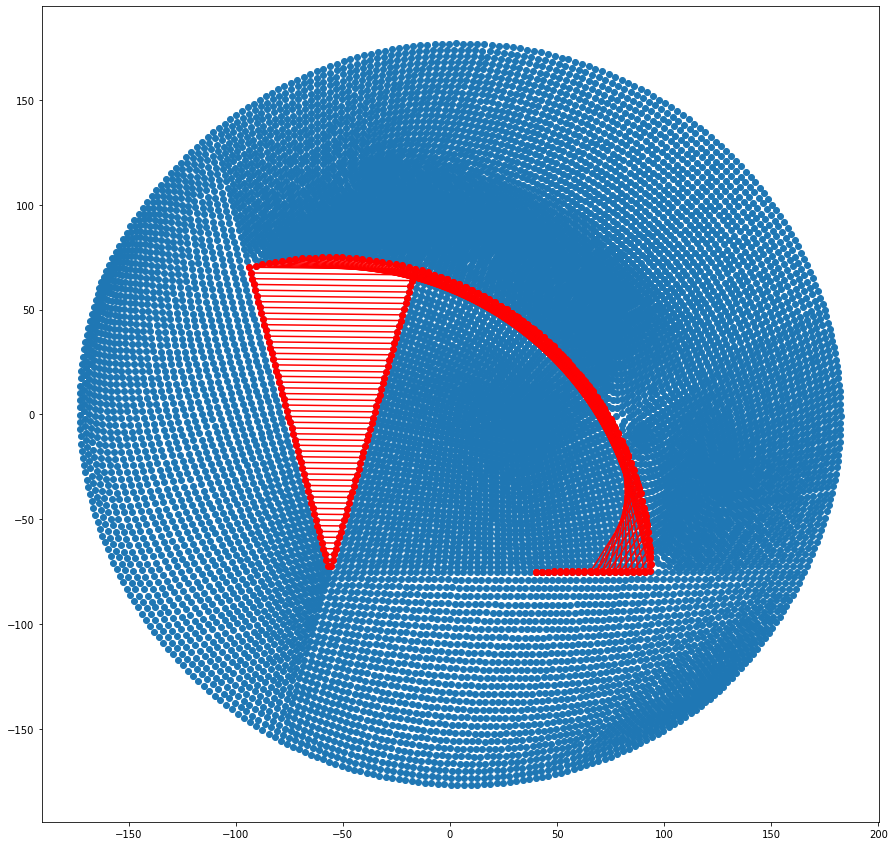

In [14]:
# Plot the stiching pairs
plt.scatter(x, y)
for i in range(0, len(stitchO)):
    plt.plot([coords[int(stitchO[i]) - 1][1],  coords[int(stitchI[i]) - 1][1]], [coords[int(stitchO[i]) - 1][2],  coords[int(stitchI[i]) - 1][2]], 'ro-')

In [15]:
# WRITE TO THE NEW INPUT FILE
# Open and read in base input file
linesINP = open(AbaqusINP+".inp",'r')
i = 0
lines = []
for line in linesINP:
    lines.append(line)
    if line == '*End Part\n':
        endPart = i
    i += 1

# Close base inputs file
linesINP.close()

In [16]:
# Determine how many nodes and elements you have
for i in range(0, len(lines)):
    if lines[i][0:8] == '*Element':
        break
n_nodes = int(lines[i-1].strip().split(',')[0])

# Get total number of elements
for i in range(0, len(lines)):
    if lines[i] == '*End Part\n':
        break
n_elems_1 = int(lines[i-1].strip().split(',')[0])

for i in range(0, len(lines)):
    if lines[i] == '*Element, type=CPS3\n':
        break
n_elems_2 = int(lines[i-1].strip().split(',')[0])

n_elems = max(n_elems_1, n_elems_2)

# Confirm you got the right numbers
print(n_elems)
print(n_nodes)

# Build overall node and element sets
sets = ['*Nset, nset=Set-1, generate\n']
sets.append('1,'+str(n_nodes) + ', 1\n')
sets.append('*Elset, elset=SKIN_element, generate\n')
sets.append('1,'+str(n_elems) + ', 1\n')

# Insert the new lines, adjusting i to know where the end of the files is
i = endPart
for set in sets:
    lines.insert(i, set)
    i += 1

12244
12561


In [17]:
# Add material parameters for skin
# Define these lines
skinParams = ['**\n', 
              '*ORIENTATION, NAME=ORI\n', 
              '-0.9885573278588885, 0.15084564805288259, 0., -0.15084564805288259, -0.9885573278588885, 0.\n', 
              '3, 0.\n', 
              '*SOLID SECTION, ELSET=SKIN_element, MATERIAL=SKIN_HOLZ, ORIENTATION=ORI\n']

# Add these parameters, again adjusting i
for param in skinParams:
    lines.insert(i, param)
    i += 1

In [18]:
# Create connectors for stitches
instname = 'rotflap-1'

# Locate the end of the assembly
for i in range(0, len(lines)):
    if lines[i] == '*End Assembly\n':
        endAssem = i
        print(endAssem)
        break
        
# Initialize the connector set
connectors = ['**\n', '*Element, type=CONN2D2\n']

# Use the overall stitching sets to create the connectors
for i in range(0, len(stitchO)):
   connectors.append(str(i+1) + ', ' + instname + '.' + str(int(stitchO[i])) + ', ' + instname + '.' + str(int(stitchI[i])) + '\n')

# Adjust i
i = endAssem - 1
for conn in connectors:
    lines.insert(i, conn)
    i += 1

# Create a section for the connectors
lines.insert(i, '*Connector Section, elset=Set-2\n')
lines.insert(i+1, 'Axial,\n')

24835


In [19]:
#Create node set for skin
for i in range(0, len(lines)):
    if lines[i] == 'Axial,\n':
        endConSec = i
        break
nset = ['*Nset, nset=SKINNODE, instance=' + instname + '\n']

# Add lines for this node set, putting 15 nodes per line
j = 0
nline = ' '
for i in range(1, len(coords)+1, 1):
    if j == 15 or i == len(coords):
        nline = nline + str(i) + '\n'
        nset.append(nline)
        j = 1
        nline = ' '
    else:
        nline = nline + str(i) + ', '
        j += 1

# Add lines
i = endConSec + 1
for n in nset:
    lines.insert(i, n)
    i += 1

In [20]:
# Create wire sets for the stitches
# Figure out where the node set ends
for i in range(0, len(lines)):
    if lines[i] == nset[-1]:
        endNset = i
        break
        
# Create wires, similar to connectors
wires = []
for i in range(0, len(stitchO)):
    wires.append('*Nset, nset=WIRE-' + str(i+1) + ', instance=' + instname + '\n')
    wires.append(' ' + str(int(stitchO[i])) + ', ' + str(int(stitchI[i])) + '\n')

# Add lines
i = endNset + 1
for wire in wires:
    lines.insert(i, wire)
    i += 1


In [21]:
# Create node set for fixed nodes
# Figure out where the wires end
for i in range(0, len(lines)):
    if lines[i] == wires[-1]:
        endWires = i
        break

# Write out node set, 15 nodes per line
nset = ['*Nset, nset=fix, internal, instance=' + instname + '\n']
fix = sorted(fix)
j = 0
nline = ' '
for i in range(0, len(fix), 1):
    if j == 15 or i == len(fix)-1:
        nline = nline + str(int(fix[i])) + '\n'
        nset.append(nline)
        j = 1
        nline = ' '
    else:
        nline = nline + str(int(fix[i])) + ', '
        j += 1

# Add to the file
i = endWires + 1
for n in nset:
    lines.insert(i, n)
    i += 1

In [22]:
# Create element sets 
for i in range(0, len(lines)):
    if lines[i] == nset[-1]:
        endSet = i
        break

# Initialize element set
elSet = ['*Elset, elset=Set-2, internal, generate\n']
elSet.append('1, ' + str(int(len(distances))) + ', 1\n') 

# Add for each stitch
n = 1
for i in range(1, len(distances)+1):
    elSet.append('*Elset, elset=_PickedSet'+str(int(n))+', internal\n')
    elSet.append(' ' + str(int(i))+',\n')
    n += 1
    
# Add to file
i = endSet + 1
for el in elSet:
    lines.insert(i, el)
    i+=1

In [23]:
# Add material parameters
matParams = ['**\n', 
             '** MATERIALS\n',
             '**\n',
             '*Material, name=SKIN_HOLZ\n',
             '*Anisotropic Hyperelastic, holzapfel, local direction=1\n',
             '0.051376, 0.0005, 21.157203, 60.480896, 0.252729\n',
             '**22.49,  0.0005, 4909.2,  76.641,  0.1\n',
             '** C10, D, k1, k2, kappa\n',
             '**DISTRIBUTION TABLE, NAME=DISTORI_TABLE\n',
             '**COORD3D,COORD3D\n',
             '**DISTRIBUTION TABLE, NAME=ANGLETABLE\n',
             '**ANGLE\n']
for param in matParams:
    lines.append(param)
             

In [24]:
# Boundary conditions - Fix nodes
fixConditions = ['**\n',
                 '**BOUNDARY CONDITIONS\n',
                 '**\n',
                 '** Name: fixednodes Type: Symmetry/Antisymmetry/Encastre\n'
                '*BOUNDARY\n',
                'fix, ENCASTRE\n',
                '**\n']
for condition in fixConditions:
    lines.append(condition)

In [25]:
# Boundary conditions - Step 1 - the line bit
step_1 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-1\n',
         '**\n',
         '*Step, name=Step-1, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define connector motion
n = 1
for i in range(len(distances_LINE)):
    step_1.append('** Name: ConnDisp-BC-'+ str(int(n)) + ' Type: Connector displacement\n')
    step_1.append('*Connector Motion\n')
    step_1.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[i]*10)/10)+'\n')
    n+=1
endN = n
 
# Add step
for line in step_1:
    lines.append(line)
    
# Add output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-1\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-2\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-3\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-1\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)


In [26]:
# Boundary conditions - Step 2 - circle part
step_2 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-2\n',
         '**\n',
         '*Step, name=Step-2, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define connector motion
n = endN
for i in range(len(distances_CIRC)):
    step_2.append('** Name: ConnDisp-BC-'+ str(int(n)) + 'Type: Connector displacement\n')
    step_2.append('*Connector Motion\n')
    step_2.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[n-1]*10)/10)+'\n')
    n+=1
endN = n

# Add step
for line in step_2:
    lines.append(line)
    
# Add output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-4\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-5\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-6\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-2\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)

In [27]:
# Boundary conditions - Step 3 - Y junction

step_3 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-3\n',
         '**\n',
         '*Step, name=Step-3, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define connector motions
n = endN
for i in range(len(distances_TRI)-2):
    step_3.append('** Name: ConnDisp-BC-'+ str(int(n)) + 'Type: Connector displacement\n')
    step_3.append('*Connector Motion\n')
    step_3.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[n-1]*10)/10)+'\n')
    n+=1
endN = n
n = endN
    
# Add to file
for line in step_3:
    lines.append(line)
    
# Add output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-7\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-8\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-9\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-3\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)

In [28]:
# Step 4 - the last stitch
step_4 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-4\n',
         '**\n',
         '*Step, name=Step-4, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define connector motion
n = endN
for i in range(0, 2):
    step_4.append('** Name: ConnDisp-BC-'+ str(int(n)) + 'Type: Connector displacement\n')
    step_4.append('*Connector Motion\n')
    step_4.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[n-1]*10)/10)+'\n')
    n+=1
endN = n

# Add to file
for line in step_4:
    lines.append(line)
    
# Add output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-10\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-11\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-12\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-4\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)

In [29]:
# Write new input file
with open('Base_Rotation.inp', 'w') as f:
    for line in lines:
        f.write("%s" % line)